In [3]:
!python3 -m pip install yolov4

In [27]:
from yolov4.tf import YOLOv4
from PIL import Image
import cv2
import numpy as np
import torch

In [11]:
pillar_yolo = YOLOv4()

pillar_yolo.classes = "pillar.names"

pillar_yolo.make_model()
pillar_yolo.load_weights("pillar.weights", weights_type="yolo")

In [28]:
insulator_yolo = YOLOv4()

insulator_yolo.classes = "insulator.names"

insulator_yolo.make_model()
insulator_yolo.load_weights("insulator.weights", weights_type="yolo")

In [31]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(6, 16,kernel_size=5),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 16,kernel_size=5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,16,kernel_size=5),
            nn.ConvTranspose2d(16, 16, 2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ConvTranspose2d(6, 6, 2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def shit(self, x):
        return self.encoder(x)

encoder = torch.load("encoder.model")
encoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (4): ConvTranspose2d(6, 6, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(6, 1, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
)

In [32]:
import pickle
with open("anomaly.model", "br") as f:
    anomaly_model = f.read()
    anomaly_model = pickle.loads(anomaly_model)

In [45]:
im = Image.open("example.jpg")
bb = pillar_yolo.predict(np.array(im))

In [80]:
transform=transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])

def get_broken_insulators(img, pillar_bb):
    width, height = img.size
    x1 = (width * (float(pillar_bb[0]) - float(pillar_bb[2]) / 2))
    y1 = (height * (float(pillar_bb[1]) - float(pillar_bb[3]) / 2))
    x2 = (width * (float(pillar_bb[0]) + float(pillar_bb[2]) / 2))
    y2 = (height * (float(pillar_bb[1]) + float(pillar_bb[3]) / 2))
    pillar = img.crop((x1, y1, x2, y2))
    
    pred = insulator_yolo.predict(np.array(pillar))
    broken = []
    for bb in pred:
        width, height = pillar.size
        x1 = (width * (float(bb[0]) - float(bb[2]) / 2))
        y1 = (height * (float(bb[1]) - float(bb[3]) / 2))
        x2 = (width * (float(bb[0]) + float(bb[2]) / 2))
        y2 = (height * (float(bb[1]) + float(bb[3]) / 2))
        insul = pillar.crop((x1, y1, x2, y2))
        insul = insul.resize((64, 64))
        encoded = encoder.shit(Variable(torch.reshape(transform(insul), (1, 1, 64, 64))).cpu())
        output = encoded[0, :, :, :].detach().numpy().reshape(1, -1)
        
        is_broken = anomaly_model.predict(output)
        if is_broken[0] == -1:
            broken.append(pillar.crop((x1, y1, x2, y2)))
    return broken
    


In [81]:
a = get_broken_insulators(im, bb[0])

ValueError: not enough values to unpack (expected 3, got 0)

[]

In [84]:
im = Image.open("broken2.JPG")
bb = pillar_yolo.predict(np.array(im))

In [85]:
b = get_broken_insulators(im, bb[0])

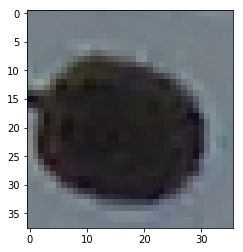

In [88]:
import matplotlib.pyplot as plt
plt.imshow(b[0])